# HomeWork 1 Problem 2

# Matthew Anderson | 801203905

# Github https://github.com/Mand187/Intro-to-ML


In [40]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Problem 2A

In [41]:
def loadAndPreprocessData(url):
    data = pd.read_csv(url)
    xData = data.drop(columns=['price'])
    yData = data['price']

    labelEncoder = LabelEncoder()

    for column in xData.columns:
        if xData[column].dtype == 'object':
            xData[column] = labelEncoder.fit_transform(xData[column])

    xTrain, xVal, yTrain, yVal = train_test_split(xData, yData, test_size=0.2, random_state=42)

    powerTransformer = PowerTransformer()
    xTrainTransformed = powerTransformer.fit_transform(xTrain)
    xValTransformed = powerTransformer.transform(xVal)

    xTrainTensor = torch.tensor(xTrainTransformed, dtype=torch.float32)
    xValTensor = torch.tensor(xValTransformed, dtype=torch.float32)
    yTrainTensor = torch.tensor(yTrain.values, dtype=torch.float32).view(-1, 1)
    yValTensor = torch.tensor(yVal.values, dtype=torch.float32).view(-1, 1)

    return xTrainTensor, xValTensor, yTrainTensor, yValTensor

class MLPModel(nn.Module):
    def __init__(self, inputDim):
        super(MLPModel, self).__init__()
        self.layer1 = nn.Linear(inputDim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.outputLayer = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.outputLayer(x)
        return x

def trainModel(model, xTrain, yTrain, xVal, yVal, numEpochs=100, batchSize=32, learningRate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learningRate)
    trainDataset = TensorDataset(xTrain, yTrain)
    valDataset = TensorDataset(xVal, yVal)
    trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
    valLoader = DataLoader(valDataset, batch_size=batchSize, shuffle=False)
    trainLosses = []
    valLosses = []
    trainRMSE = []
    valRMSE = []
    trainMAE = []
    valMAE = []

    for epoch in range(numEpochs):
        model.train()
        runningTrainLoss = 0.0
        runningTrainRMSE = 0.0
        runningTrainMAE = 0.0
        for inputs, labels in trainLoader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            runningTrainLoss += loss.item() * inputs.size(0)
            runningTrainRMSE += np.sqrt(mean_squared_error(labels.detach().numpy(), outputs.detach().numpy())) * inputs.size(0)
            runningTrainMAE += mean_absolute_error(labels.detach().numpy(), outputs.detach().numpy()) * inputs.size(0)

        avgTrainLoss = runningTrainLoss / len(trainLoader.dataset)
        avgTrainRMSE = runningTrainRMSE / len(trainLoader.dataset)
        avgTrainMAE = runningTrainMAE / len(trainLoader.dataset)

        trainLosses.append(avgTrainLoss)
        trainRMSE.append(avgTrainRMSE)
        trainMAE.append(avgTrainMAE)

        model.eval()
        runningValLoss = 0.0
        runningValRMSE = 0.0
        runningValMAE = 0.0
        with torch.no_grad():
            for inputs, labels in valLoader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                runningValLoss += loss.item() * inputs.size(0)
                runningValRMSE += np.sqrt(mean_squared_error(labels.detach().numpy(), outputs.detach().numpy())) * inputs.size(0)
                runningValMAE += mean_absolute_error(labels.detach().numpy(), outputs.detach().numpy()) * inputs.size(0)

        avgValLoss = runningValLoss / len(valLoader.dataset)
        avgValRMSE = runningValRMSE / len(valLoader.dataset)
        avgValMAE = runningValMAE / len(valLoader.dataset)

        valLosses.append(avgValLoss)
        valRMSE.append(avgValRMSE)
        valMAE.append(avgValMAE)

        if (epoch + 1) % 100 == 0:  # Report every 100 epochs
            print(f'Epoch [{epoch+1}/{numEpochs}], Training Loss: {avgTrainLoss:.2e}, Validation Loss: {avgValLoss:.2e}, '
                  f'Training RMSE: {avgTrainRMSE:.2e}, Validation RMSE: {avgValRMSE:.2e}, '
                  f'Training MAE: {avgTrainMAE:.2e}, Validation MAE: {avgValMAE:.2e}')

    return trainLosses, valLosses, trainRMSE, valRMSE, trainMAE, valMAE

def plotTrainingResults(trainLosses, valLosses, trainRMSE, valRMSE, trainMAE, valMAE):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    axs[0].plot(trainLosses, label='Training Loss')
    axs[0].plot(valLosses, label='Validation Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(trainRMSE, label='Training RMSE')
    axs[1].plot(valRMSE, label='Validation RMSE')
    axs[1].plot(trainMAE, label='Training MAE')
    axs[1].plot(valMAE, label='Validation MAE')
    axs[1].set_title('Training and Validation RMSE & MAE')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Error')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

def reportFinalMetrics(model, trainLosses, valLosses, trainRMSE, valRMSE, trainMAE, valMAE):
    finalTrainLoss = trainLosses[-1]
    finalValLoss = valLosses[-1]
    finalTrainRMSE = trainRMSE[-1]
    finalValRMSE = valRMSE[-1]
    finalTrainMAE = trainMAE[-1]
    finalValMAE = valMAE[-1]

    print(f"Final Training Loss (MSE): {finalTrainLoss:.2e}")
    print(f"Final Validation Loss (MSE): {finalValLoss:.2e}")
    print(f"Final Training RMSE: {finalTrainRMSE:.2e}")
    print(f"Final Validation RMSE: {finalValRMSE:.2e}")
    print(f"Final Training MAE: {finalTrainMAE:.2e}")
    print(f"Final Validation MAE: {finalValMAE:.2e}")

    modelComplexity = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model Complexity (Number of parameters): {modelComplexity}")

Epoch [100/1000], Training Loss: 2.48e+13, Validation Loss: 2.96e+13, Training RMSE: 4.96e+06, Validation RMSE: 5.40e+06, Training MAE: 4.67e+06, Validation MAE: 4.97e+06
Epoch [200/1000], Training Loss: 2.25e+13, Validation Loss: 2.68e+13, Training RMSE: 4.73e+06, Validation RMSE: 5.15e+06, Training MAE: 4.47e+06, Validation MAE: 4.76e+06
Epoch [300/1000], Training Loss: 1.83e+13, Validation Loss: 2.18e+13, Training RMSE: 4.27e+06, Validation RMSE: 4.64e+06, Training MAE: 4.07e+06, Validation MAE: 4.34e+06
Epoch [400/1000], Training Loss: 1.34e+13, Validation Loss: 1.59e+13, Training RMSE: 3.65e+06, Validation RMSE: 3.97e+06, Training MAE: 3.49e+06, Validation MAE: 3.73e+06
Epoch [500/1000], Training Loss: 9.46e+12, Validation Loss: 1.09e+13, Training RMSE: 3.07e+06, Validation RMSE: 3.29e+06, Training MAE: 2.85e+06, Validation MAE: 3.03e+06
Epoch [600/1000], Training Loss: 7.28e+12, Validation Loss: 8.02e+12, Training RMSE: 2.69e+06, Validation RMSE: 2.83e+06, Training MAE: 2.41e+06,

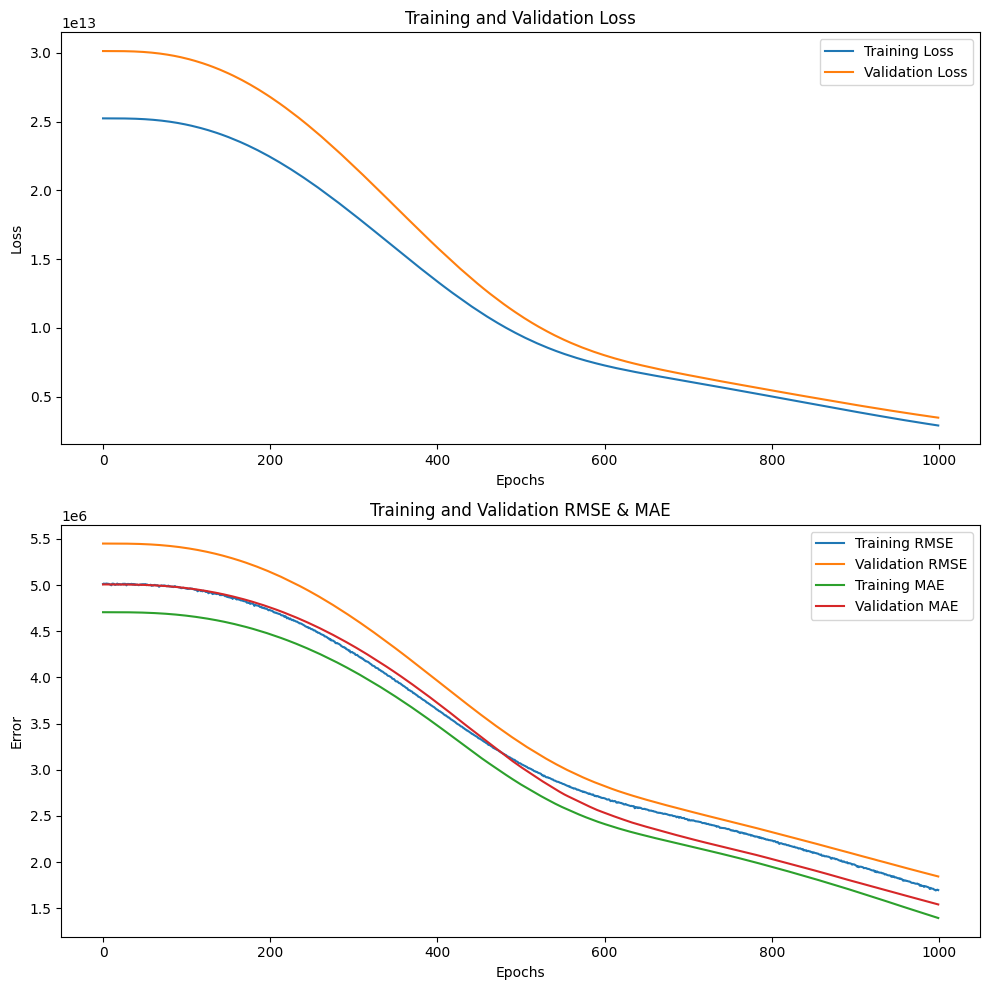

Final Training Loss (MSE): 2.90e+12
Final Validation Loss (MSE): 3.47e+12
Final Training RMSE: 1.70e+06
Final Validation RMSE: 1.84e+06
Final Training MAE: 1.39e+06
Final Validation MAE: 1.54e+06
Model Complexity (Number of parameters): 2945


In [42]:
url = "https://raw.githubusercontent.com/Mand187/Intro-to-ML/refs/heads/master/Data/Housing.csv"
xTrainTensor, xValTensor, yTrainTensor, yValTensor = loadAndPreprocessData(url)
model = MLPModel(xTrainTensor.shape[1])

trainLosses, valLosses, trainRMSE, valRMSE, trainMAE, valMAE = trainModel(model, xTrainTensor, yTrainTensor, xValTensor, yValTensor, numEpochs=1000)

plotTrainingResults(trainLosses, valLosses, trainRMSE, valRMSE, trainMAE, valMAE)
reportFinalMetrics(model, trainLosses, valLosses, trainRMSE, valRMSE, trainMAE, valMAE)

# Problem 2B

In [46]:
def dataWithOneHotEncoding(url):
    data = pd.read_csv(url)
    xData = data.drop(columns=['price'])
    yData = data['price']

    categoricalColumns = xData.select_dtypes(include=['object']).columns
    xData = pd.get_dummies(xData, columns=categoricalColumns, drop_first=True)  # One-Hot Encoding

    xTrain, xVal, yTrain, yVal = train_test_split(xData, yData, test_size=0.2, random_state=42)

    powerTransformer = PowerTransformer()
    xTrainTransformed = powerTransformer.fit_transform(xTrain)
    xValTransformed = powerTransformer.transform(xVal)

    xTrainTensor = torch.tensor(xTrainTransformed, dtype=torch.float32)
    xValTensor = torch.tensor(xValTransformed, dtype=torch.float32)
    yTrainTensor = torch.tensor(yTrain.values, dtype=torch.float32).view(-1, 1)
    yValTensor = torch.tensor(yVal.values, dtype=torch.float32).view(-1, 1)

    return xTrainTensor, xValTensor, yTrainTensor, yValTensor

class MLPModel(nn.Module):
    def __init__(self, inputDim):
        super(MLPModel, self).__init__()
        self.layer1 = nn.Linear(inputDim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.outputLayer = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.outputLayer(x)
        return x

Epoch [100/1000], Training Loss: 2.46e+13, Validation Loss: 2.94e+13, Training RMSE: 4.95e+06, Validation RMSE: 5.39e+06, Training MAE: 4.66e+06, Validation MAE: 4.95e+06
Epoch [200/1000], Training Loss: 2.15e+13, Validation Loss: 2.57e+13, Training RMSE: 4.63e+06, Validation RMSE: 5.04e+06, Training MAE: 4.38e+06, Validation MAE: 4.67e+06
Epoch [300/1000], Training Loss: 1.62e+13, Validation Loss: 1.93e+13, Training RMSE: 4.01e+06, Validation RMSE: 4.37e+06, Training MAE: 3.83e+06, Validation MAE: 4.10e+06
Epoch [400/1000], Training Loss: 1.08e+13, Validation Loss: 1.27e+13, Training RMSE: 3.28e+06, Validation RMSE: 3.55e+06, Training MAE: 3.08e+06, Validation MAE: 3.32e+06
Epoch [500/1000], Training Loss: 7.41e+12, Validation Loss: 8.26e+12, Training RMSE: 2.71e+06, Validation RMSE: 2.87e+06, Training MAE: 2.45e+06, Validation MAE: 2.59e+06
Epoch [600/1000], Training Loss: 5.83e+12, Validation Loss: 6.24e+12, Training RMSE: 2.41e+06, Validation RMSE: 2.49e+06, Training MAE: 2.14e+06,

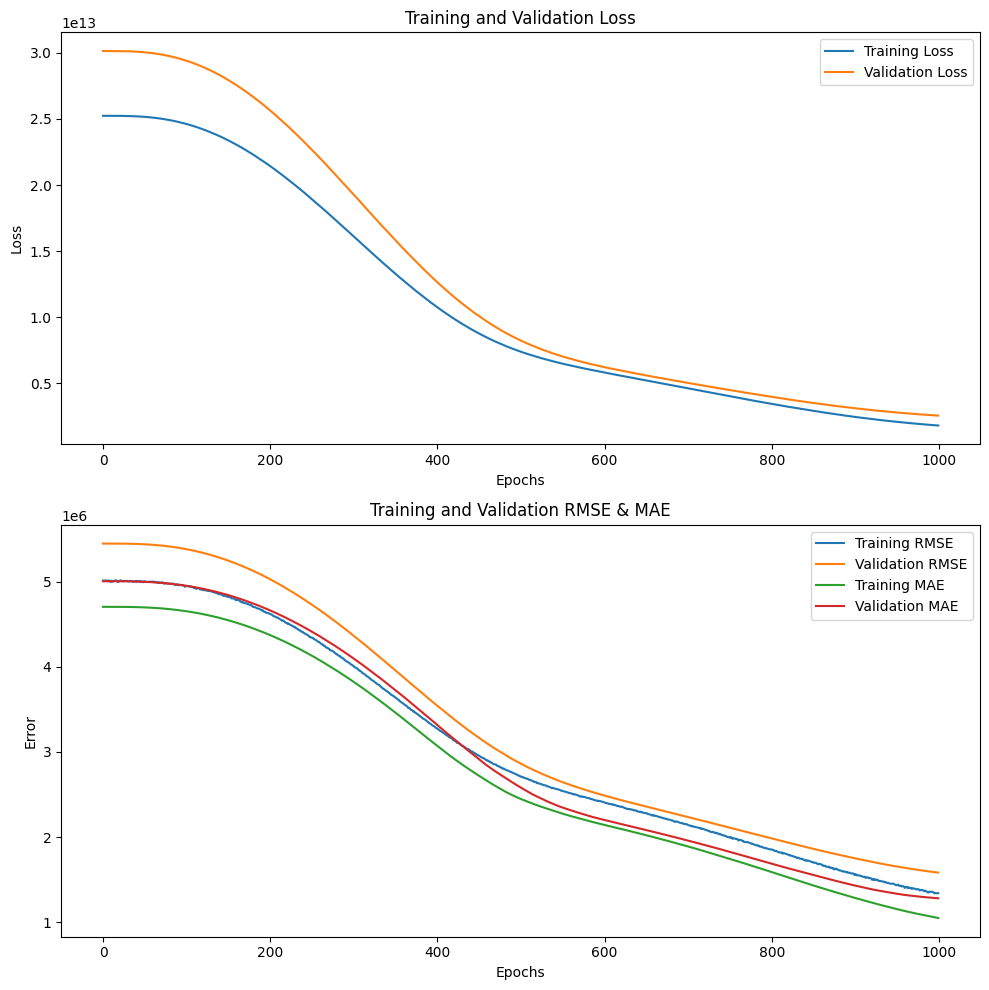

Final Training Loss (MSE): 1.82e+12
Final Validation Loss (MSE): 2.57e+12
Final Training RMSE: 1.34e+06
Final Validation RMSE: 1.58e+06
Final Training MAE: 1.05e+06
Final Validation MAE: 1.28e+06
Model Complexity (Number of parameters): 3009


In [47]:
url = "https://raw.githubusercontent.com/Mand187/Intro-to-ML/refs/heads/master/Data/Housing.csv"
xTrainTensor, xValTensor, yTrainTensor, yValTensor = dataWithOneHotEncoding(url)
model = MLPModel(xTrainTensor.shape[1])

trainLosses, valLosses, trainRMSE, valRMSE, trainMAE, valMAE = trainModel(model, xTrainTensor, yTrainTensor, xValTensor, yValTensor, numEpochs=1000)

plotTrainingResults(trainLosses, valLosses, trainRMSE, valRMSE, trainMAE, valMAE)
reportFinalMetrics(model, trainLosses, valLosses, trainRMSE, valRMSE, trainMAE, valMAE)

In [48]:
class MLPModelIncreasedComplexity(nn.Module):
    def __init__(self, inputDim):
        super(MLPModelIncreasedComplexity, self).__init__()
        self.layer1 = nn.Linear(inputDim, 128)  # Increased neurons
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 16)  # Added more layers
        self.outputLayer = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))  # Additional activation
        x = self.outputLayer(x)
        return x

Epoch [100/1000], Training Loss: 9.84e+11, Validation Loss: 1.86e+12, Training RMSE: 9.82e+05, Validation RMSE: 1.33e+06, Training MAE: 7.28e+05, Validation MAE: 1.06e+06
Epoch [200/1000], Training Loss: 8.21e+11, Validation Loss: 1.78e+12, Training RMSE: 8.80e+05, Validation RMSE: 1.30e+06, Training MAE: 6.56e+05, Validation MAE: 1.01e+06
Epoch [300/1000], Training Loss: 7.63e+11, Validation Loss: 1.77e+12, Training RMSE: 8.42e+05, Validation RMSE: 1.30e+06, Training MAE: 6.30e+05, Validation MAE: 1.01e+06
Epoch [400/1000], Training Loss: 7.23e+11, Validation Loss: 1.76e+12, Training RMSE: 8.30e+05, Validation RMSE: 1.30e+06, Training MAE: 6.09e+05, Validation MAE: 1.01e+06
Epoch [500/1000], Training Loss: 6.91e+11, Validation Loss: 1.75e+12, Training RMSE: 8.20e+05, Validation RMSE: 1.30e+06, Training MAE: 5.98e+05, Validation MAE: 1.01e+06
Epoch [600/1000], Training Loss: 6.69e+11, Validation Loss: 1.77e+12, Training RMSE: 8.02e+05, Validation RMSE: 1.30e+06, Training MAE: 5.84e+05,

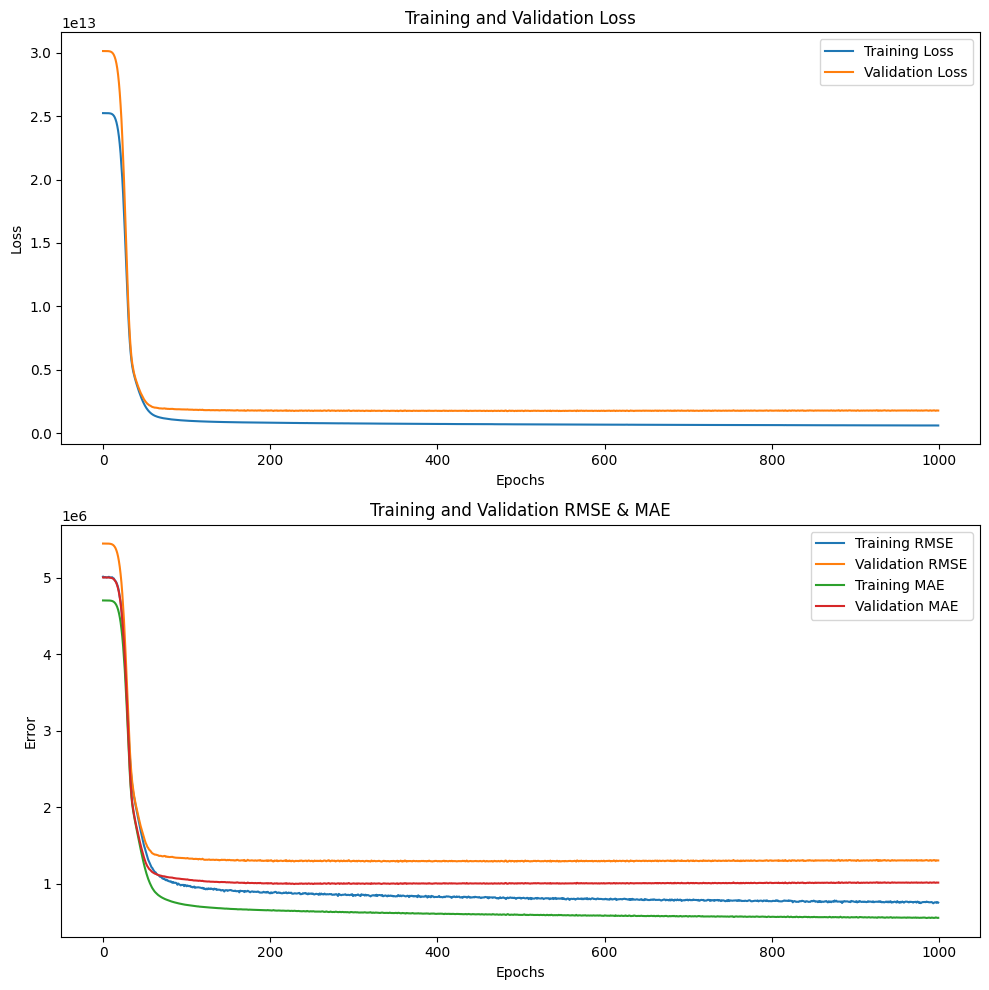

Final Training Loss (MSE): 6.00e+11
Final Validation Loss (MSE): 1.78e+12
Final Training RMSE: 7.57e+05
Final Validation RMSE: 1.31e+06
Final Training MAE: 5.57e+05
Final Validation MAE: 1.02e+06
Model Complexity (Number of parameters): 12673


In [49]:
url = "https://raw.githubusercontent.com/Mand187/Intro-to-ML/refs/heads/master/Data/Housing.csv"
xTrainTensor, xValTensor, yTrainTensor, yValTensor = dataWithOneHotEncoding(url)
model = MLPModelIncreasedComplexity(xTrainTensor.shape[1])

trainLosses, valLosses, trainRMSE, valRMSE, trainMAE, valMAE = trainModel(model, xTrainTensor, yTrainTensor, xValTensor, yValTensor, numEpochs=1000)

plotTrainingResults(trainLosses, valLosses, trainRMSE, valRMSE, trainMAE, valMAE)
reportFinalMetrics(model, trainLosses, valLosses, trainRMSE, valRMSE, trainMAE, valMAE)